In [1]:
from melee_dataset import MeleeDataset
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch

In [2]:
train_dataset = MeleeDataset(data_path="data/train_mini_50")
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [3]:
print(f"obs_dim: {train_dataset[0][0].shape}")
print(f"act_dim: {train_dataset[0][1].shape}")

obs_dim: torch.Size([54])
act_dim: torch.Size([17])


In [4]:
class PolicyNet(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 64), nn.ReLU(),
            nn.Linear(64, 64),      nn.ReLU(),
            nn.Linear(64, act_dim)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
obs_dim = train_dataset[0][0].shape[0]
act_dim = train_dataset[0][1].shape[0]
policy  = PolicyNet(obs_dim, act_dim).to(device)
opt     = optim.Adam(policy.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()  

Using device: cuda


In [5]:
losses = []
for epoch in range(5):
    total_loss = 0.0
    for batch in tqdm(train_loader):
        batch_states = batch[0].to(device)
        batch_actions = batch[1].to(device)
        pred = policy(batch_states)
        loss = loss_fn(pred, batch_actions)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item() * batch_states.size(0)
        losses.append(loss.item())
    avg_loss = total_loss / len(train_dataset)
    print(f"Epoch {epoch+1} — Loss: {avg_loss:.4f}")

100%|██████████| 4547/4547 [01:22<00:00, 55.05it/s] 


Epoch 1 — Loss: 0.1088


100%|██████████| 4547/4547 [00:06<00:00, 713.84it/s]


Epoch 2 — Loss: 0.0078


100%|██████████| 4547/4547 [00:06<00:00, 680.23it/s]


Epoch 3 — Loss: 0.0057


100%|██████████| 4547/4547 [00:06<00:00, 686.67it/s]


Epoch 4 — Loss: 0.0053


100%|██████████| 4547/4547 [00:06<00:00, 702.21it/s]

Epoch 5 — Loss: 0.0052


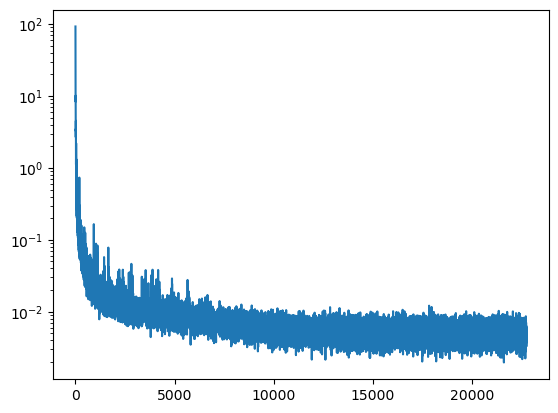

In [15]:
import matplotlib.pyplot as plt

plt.yscale('log')
plt.plot(range(len(losses)), losses)